In [2]:
from __future__ import print_function
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    

In [4]:

def train(model, device, train_loader, optimizer, epoch,log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset)

In [13]:

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

batch_size = 64
test_batch_size = 1000
epochs = 30
lr = 1.0
gamma = 0.7
no_cuda = False
seed=1
log_interval = 10
save_model = False

use_cuda = not no_cuda and torch.cuda.is_available() 
torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


In [7]:
from generate_increasing_dataset import generate_delta_probability

step = 5
training_dataset_size = 1000
dataset_size = 1000

In [8]:
base_vector = [ 0.01 for i in range(10)]
final_vector = [ 0 for i in range(10)]



final_vector[0] = 1.0
base_vector[1] = 0.91


repartition_list = generate_delta_probability(base_vector, final_vector, step)

transform = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
for repartition in repartition_list:
    print(repartition_list)

[{0: 0.01, 1: 0.91, 2: 0.01, 3: 0.01, 4: 0.01, 5: 0.01, 6: 0.01, 7: 0.01, 8: 0.01, 9: 0.01}, {0: 0.20800000000000002, 1: 0.728, 2: 0.008, 3: 0.008, 4: 0.008, 5: 0.008, 6: 0.008, 7: 0.008, 8: 0.008, 9: 0.008}, {0: 0.406, 1: 0.546, 2: 0.006, 3: 0.006, 4: 0.006, 5: 0.006, 6: 0.006, 7: 0.006, 8: 0.006, 9: 0.006}, {0: 0.6040000000000001, 1: 0.364, 2: 0.004, 3: 0.004, 4: 0.004, 5: 0.004, 6: 0.004, 7: 0.004, 8: 0.004, 9: 0.004}, {0: 0.802, 1: 0.18200000000000005, 2: 0.002, 3: 0.002, 4: 0.002, 5: 0.002, 6: 0.002, 7: 0.002, 8: 0.002, 9: 0.002}, {0: 1.0, 1: 1.1102230246251565e-16, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}]
[{0: 0.01, 1: 0.91, 2: 0.01, 3: 0.01, 4: 0.01, 5: 0.01, 6: 0.01, 7: 0.01, 8: 0.01, 9: 0.01}, {0: 0.20800000000000002, 1: 0.728, 2: 0.008, 3: 0.008, 4: 0.008, 5: 0.008, 6: 0.008, 7: 0.008, 8: 0.008, 9: 0.008}, {0: 0.406, 1: 0.546, 2: 0.006, 3: 0.006, 4: 0.006, 5: 0.006, 6: 0.006, 7: 0.006, 8: 0.006, 9: 0.006}, {0: 0.6040000000000001, 1: 0.364, 2: 0.004, 3:

In [10]:
from dataset_generator.generate_dataset import partionate_dataset_repetition

reference_dataset = datasets.MNIST('../data',
                       transform=transform
)

training_dataset = datasets.MNIST('../data',
                       transform=transform
)

train_data,train_targets = partionate_dataset_repetition(
        reference_dataset.data,
        reference_dataset.targets, 
        repartition_list[0] ,
        training_dataset_size
    )

training_dataset.data = train_data
training_dataset.targets = train_targets

train_loader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=batch_size, 
    shuffle=True, 
    **kwargs
)


In [11]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [17]:
for epoch in range(1, epochs + 1):

        train(model, device, train_loader, optimizer, epoch,log_interval)
        scheduler.step()



Train Epoch: 1 [0/1000 (0%)]	Loss: 0.084392
Train Epoch: 1 [640/1000 (62%)]	Loss: 0.125147
Train Epoch: 2 [0/1000 (0%)]	Loss: 0.122905
Train Epoch: 2 [640/1000 (62%)]	Loss: 0.096792
Train Epoch: 3 [0/1000 (0%)]	Loss: 0.145976
Train Epoch: 3 [640/1000 (62%)]	Loss: 0.084977
Train Epoch: 4 [0/1000 (0%)]	Loss: 0.082786
Train Epoch: 4 [640/1000 (62%)]	Loss: 0.145396
Train Epoch: 5 [0/1000 (0%)]	Loss: 0.059362
Train Epoch: 5 [640/1000 (62%)]	Loss: 0.059283
Train Epoch: 6 [0/1000 (0%)]	Loss: 0.053506
Train Epoch: 6 [640/1000 (62%)]	Loss: 0.059492
Train Epoch: 7 [0/1000 (0%)]	Loss: 0.099732
Train Epoch: 7 [640/1000 (62%)]	Loss: 0.055632
Train Epoch: 8 [0/1000 (0%)]	Loss: 0.103052
Train Epoch: 8 [640/1000 (62%)]	Loss: 0.045682
Train Epoch: 9 [0/1000 (0%)]	Loss: 0.030153
Train Epoch: 9 [640/1000 (62%)]	Loss: 0.092624
Train Epoch: 10 [0/1000 (0%)]	Loss: 0.030818
Train Epoch: 10 [640/1000 (62%)]	Loss: 0.045570
Train Epoch: 11 [0/1000 (0%)]	Loss: 0.043220
Train Epoch: 11 [640/1000 (62%)]	Loss: 0.07

In [15]:
if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

In [16]:

data_and_label_list = [
    partionate_dataset_repetition(
        reference_dataset.data,
        reference_dataset.targets, 
        probability ,
        dataset_size
    ) for probability in repartition_list 
]

dataset_list = [ 
    datasets.MNIST(
        '../data',
        transform=transform
    )
     for i in range(len(data_and_label_list))
]

test_list = []

for dataset,data_label in zip(dataset_list,data_and_label_list):

    data_p,label_p = data_label

    dataset.data = data_p
    dataset.targets = label_p

    test_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=test_batch_size, 
        shuffle=True, 
        **kwargs
    )

    test_list.append(test_loader)





In [31]:
from distance.distance import distance_vector_dict

delta_y = []
delta_x = [distance_vector_dict(
    repartition_list[0],
    repartition_list[i]
    ) for i in range(len(repartition_list))
]


for test_loader in test_list:
    
    accuracy = test(model,device,test_loader)/100
    delta_y.append(accuracy)


Test set: Average loss: 0.0557, Accuracy: 982/1000 (98%)


Test set: Average loss: 0.0807, Accuracy: 978/1000 (98%)


Test set: Average loss: 0.1051, Accuracy: 973/1000 (97%)


Test set: Average loss: 0.1219, Accuracy: 970/1000 (97%)


Test set: Average loss: 0.1343, Accuracy: 968/1000 (97%)


Test set: Average loss: 0.1384, Accuracy: 970/1000 (97%)



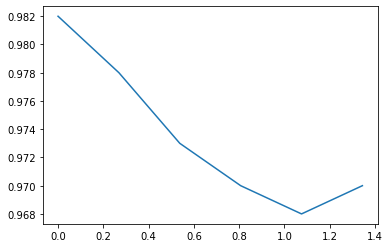

In [32]:
#import matplotlib
#import tk
import matplotlib.pyplot as plt

#matplotlib.use('TkAgg')

plt.plot(delta_x,delta_y)
plt.show()